In [1]:
# =======================================================================================================
# Code was runned using Docker on top of Ubuntu 22.04.1 LTS with Nvidia drivers 510. 
# Image: tensorflow/tensorflow:latest-gpu-jupyter
# CUDA version: 11.6 
# =======================================================================================================
# Run with: 
#        docker pull tensorflow/tensorflow:latest-gpu-jupyter
#        docker run --rm -it --gpus 0 --name=pong_tensorflow -p8888:8888 tensorflow/tensorflow:latest-gpu-jupyter
# =======================================================================================================
# In another shell:
#        docker cp A3C-Pong.ipynb pong_tensorflow:/tf/
# Accessing from browser, uncomment the code below to install all the proper software. 
# Re-comment it as soon as it finishes.
# =======================================================================================================
# Access output file with another shell:
#        docker exec -it pong_tensorflow bash
#        # tail -f Pong/output.txt
# =======================================================================================================

In [2]:
# =======================================================================================================
#!apt-get update
#!apt-get install -y xvfb ffmpeg cmake wget unrar python-opengl x11-utils
#!apt-get upgrade --yes 
#
#!pip install --upgrade pip
#!pip install gym[atari] opencv-python atari-py pyglet pyvirtualdisplay ale-py lz4 gym-notebook-wrapper --upgrade
# =======================================================================================================
#!SHELL=/bin/bash
#!if [ ! -f 'Roms.rar' ] ; then wget http://www.atarimania.com/roms/Roms.rar ; unrar e Roms.rar ; fi
#!python -m atari_py.import_roms . 
# =======================================================================================================

In [3]:
# =======================================================================================================
import os
import time
import matplotlib
import cv2
import gym
import time
import multiprocessing
import pickle
import shutil
# =======================================================================================================
import tensorflow        as tf
import numpy             as np
import matplotlib.pyplot as plt
# =======================================================================================================
from time                import gmtime, strftime
from collections         import deque
from gym                 import envs
from gym.wrappers        import FrameStack, GrayScaleObservation, ResizeObservation, AutoResetWrapper
from IPython             import display
from threading           import Thread, Lock
from typing              import List, Tuple
# =======================================================================================================

In [4]:
# =======================================================================================================
# tf.keras.backend.set_floatx('float32') # set keras default floating point precision type
tf_fpp = tf.float32                      # tf floating point precision type 
np_fpp = np.float32                      # np floating point precision type
tf.keras.backend.clear_session()
# =======================================================================================================

In [5]:
# =======================================================================================================
maximum_number_of_workers = 64           # Single out-of-context variable to specify the maximum number of 
                                         # threads to run in parallel. This because of the creation of an array
                                         # of environments in used in a **static** context in order to apply 
                                         # the @tf.function annotation and speed up the whole process.
            
                                         # Otherwise, calls to functions of non-static variables in an OO 
                                         # context would've required the *self* starting argument, not 
                                         # convertible to a Tensor, therefore not allowing the conversion to graph.
# =======================================================================================================

In [6]:
# =======================================================================================================
# CropObservation wrapper crops the image(s) in input to a specified dimension. 
# =======================================================================================================
class CropObservation(gym.ObservationWrapper):

    def __init__(self, environment, kwargs):
        super().__init__(environment)
        self.x_low  = kwargs["x_low"]
        self.x_high = kwargs["x_high"]
        self.y_low  = kwargs["y_low"]
        self.y_high = kwargs["y_high"]

    def observation(self, observation):
        observation = observation[self.y_low:self.y_high, self.x_low:self.x_high]
        return observation
# =======================================================================================================

# =======================================================================================================
# DenoiseObservation wrapper uses computer vision's adaptive threshold function to highlight important features.
# Original function documentation can be found here [https://docs.opencv.org/3.4/d7/d4d/tutorial_py_thresholding.html]
# =======================================================================================================
class DenoiseObservation(gym.ObservationWrapper):
  
    def __init__(self, env):
        super().__init__(env)
    
    def observation(self, observation):
        observation = cv2.adaptiveThreshold(observation, 255., cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 3, 2)
        return observation
# =======================================================================================================
  
    
# =======================================================================================================
# NormalizeObservation wrapper divides the uint8 pixels by their max value (255.) in order to scale it to a value
# between 0 and 1. This reduces the variance of values in the neural network.
# =======================================================================================================
class NormalizeObservation(gym.ObservationWrapper):
    
    def __init__(self, environment):
        super().__init__(environment)
        
    def observation(self, observation):
        observation = tf.cast(observation, dtype=tf.float32)
        observation = tf.divide(observation, 255.)
        return observation
# =======================================================================================================

# =======================================================================================================
# Whenever the agent loses a life, this wrapper enforces done = True
# =======================================================================================================
class TerminalOnLifeLoss(gym.Wrapper):
    
    def __init__(self, environment):
        super().__init__(environment)
        self.lives = 0
        
    def reset(self):
        obs, info = self.env.reset()
        self.lives = info["lives"]
        return obs, info
        
    def step(self, action):
        obs, reward, done, truncated, info = self.env.step(action)
        if info["lives"] < self.lives:
            done = True
            # if reward == 0:
            #     reward = -1
        return obs, reward, done, truncated, info
# =======================================================================================================

# =======================================================================================================
# Some games like Breakout require to press "Fire" to start. The agent could get stuck into a perpetual
# game where nothing happens until it performs the "Fire" move.
# =======================================================================================================
class AutoFire(gym.Wrapper): 
    
    def reset(self):
        obs, info = self.env.reset()
        obs, reward, done, truncated, info = self.env.step(1)
        return obs, info
# =======================================================================================================

# =======================================================================================================
# Function that, based on the arguments passed in the last section, automatically wraps the environment 
# =======================================================================================================
def make_env(kwargs):
    
    env = gym.make(kwargs["env_name"], render_mode=kwargs["render_mode"], frameskip=kwargs["frameskip"], 
             repeat_action_probability=kwargs["repeat_probability"], difficulty=kwargs["difficulty"])
    env = TerminalOnLifeLoss(env)
    env = AutoResetWrapper(env)
    
    if kwargs["crop"]:
        env = CropObservation(env, kwargs)
    if kwargs["grayscale"]:
        env = GrayScaleObservation(env, keep_dim=True)
    if kwargs["resize"]:
        env = ResizeObservation(env, (kwargs["screen_size"], kwargs["screen_size"]))
    if kwargs["denoise"]:
        env = DenoiseObservation(env)
    if kwargs["normalize"]: 
        env = NormalizeObservation(env)
    if kwargs["stack_frames"]:
        env = FrameStack(env, kwargs["n_frames"])

    return env
# =======================================================================================================

In [7]:
# =======================================================================================================
# Actor-Critic model as specified in the original A3C paper in section 8 (Experimental Setup) of the 
# supplementary material.
# =======================================================================================================

class ActorCriticModel(tf.keras.Model):
    
    # =======================================================================================================            
    # Leaky ReLU activation function
    # =======================================================================================================
    def leaky_relu(self, x):
        return tf.keras.activations.relu(x, alpha=self.alpha, max_value=None, threshold=0.0)
        
    def __init__(self, state_shape, action_size):

        self.alpha = 1/16.0
        
        self.state_shape     = state_shape
        self.action_size     = action_size

        inputs           = tf.keras.layers.Input(shape=self.state_shape)
        conv_1           = tf.keras.layers.Conv2D(8, 8, strides=2, activation='relu', kernel_initializer='he_uniform') (inputs)
        conv_2           = tf.keras.layers.Conv2D(16, 4, strides=2, activation='relu', kernel_initializer='he_uniform') (conv_1)
        conv_3           = tf.keras.layers.Conv2D(32, 2, strides=4, activation='relu', kernel_initializer='he_uniform') (conv_2)
        flatten          = tf.keras.layers.Flatten() (conv_3)
        dense_1          = tf.keras.layers.Dense(units=1024, activation=self.leaky_relu) (flatten)
        critic           = tf.keras.layers.Dense(units=1) (dense_1)
        actor            = tf.keras.layers.Dense(units=action_size) (dense_1) 

        super(ActorCriticModel, self).__init__(inputs=inputs, outputs=[actor, critic])



In [8]:
# =======================================================================================================            
# Object that handles the session state. Saving and loading model, optimizer, and the necessary variables
# =======================================================================================================
class Saver():
    def __init__(self, save_dir, checkpoint):
        # Directories and files where the progress is saved into
        self.save_dir = save_dir
        self.checkpoint = checkpoint
        
        self.output_file = save_dir + 'output.txt'
        self.best_score_file = save_dir + 'best_score.bin'
        self.episode_file = save_dir + 'episode.bin'
        self.deque_file = save_dir + 'deque.bin'
        self.plot_data_file = save_dir + 'plot_data.bin'
        
        self.cp_manager = tf.train.CheckpointManager(self.checkpoint, directory=save_dir, max_to_keep=2)
        
        self.lock = Lock()
        self.output_lock = Lock()
    
    # =======================================================================================================            
    # Depending on the request, either loads precedent model, optimizer, and vars, or create new ones
    # =======================================================================================================
    def restore_or_reset(self, restore, restore_from_best, moving_average_card):
        if restore:
            if restore_from_best:
                self.checkpoint.restore(self.cp_manager.checkpoints[-2])
            else:
                self.checkpoint.restore(self.cp_manager.latest_checkpoint)
            global_episode, best_score, rdeque, plot_data = self.load()
            global_moving_average_reward = np.mean(rdeque)
        else:
            global_episode, best_score, rdeque, plot_data = 0, float('-inf'), deque(maxlen=moving_average_card), []
            global_moving_average_reward = 0
            self.reset()
            
        return global_episode, best_score, rdeque, plot_data, global_moving_average_reward
    
    # =======================================================================================================            
    # Saves the session state
    # =======================================================================================================
    def save(self, episode, best_score, deque, plot_data):
        with self.lock:
            print(f'Saving model to {self.save_dir}, best episode score: {best_score}')
            self.cp_manager.save()
            self.__store_element(self.episode_file, episode)
            self.__store_element(self.best_score_file, best_score)
            self.__store_element(self.deque_file, deque)
            self.__store_element(self.plot_data_file, plot_data)
            shutil.copy2(self.output_file, self.output_file + '.bak')
            
    # =======================================================================================================            
    # Loads the session state
    # =======================================================================================================
    def load(self):
        with self.lock:
            episode = self.__load_element(self.episode_file)
            best_score = self.__load_element(self.best_score_file)
            deque = self.__load_element(self.deque_file)
            plot_data = self.__load_element(self.plot_data_file)
                 
            self.__remove_output_file()
            shutil.copy2(self.output_file + '.bak', self.output_file)
            self.serialize_output(f' --- RESTORING EPISODE {episode} - BESTSCORE {best_score} ---')
        
        return episode, best_score, deque, plot_data
    
    # =======================================================================================================            
    # Creates the save directory and removes the previous output file, if existent.
    # =======================================================================================================
    def reset(self):
        with self.lock:
            self.__make_save_dir()
            self.__remove_output_file()
            
    # =======================================================================================================            
    # Prints and serializes the output to a file
    # =======================================================================================================      
    def serialize_output(self, output):
        with self.output_lock:
            self.__make_save_dir()
            with open(self.output_file, "a") as file:
                file.write(self.__timestamp(output) + "\n"),
            print(output)
          
    # =======================================================================================================            
    # Accessory function to serialize an object
    # =======================================================================================================
    def __store_element(self, element_file, element):
        self.__make_save_dir()
        with open(element_file, "wb") as file:
            pickle.dump(element, file)        
            
    # =======================================================================================================            
    # Accessory function to load a stored object
    # =======================================================================================================   
    def __load_element(self, element_file):
        with open(element_file, "rb") as file:
            element = pickle.load(file)
        return element
    
    # =======================================================================================================            
    # Removes the output file
    # =======================================================================================================
    def __remove_output_file(self):
        if os.path.exists(self.output_file):
            os.remove(self.output_file)
            print('Removed ' + self.output_file)
            
    # =======================================================================================================            
    # Creates the save directory.
    # =======================================================================================================        
    def __make_save_dir(self):
        if not os.path.isdir(self.save_dir):
            os.makedirs(self.save_dir)
            
    # =======================================================================================================            
    # Adds a timestamp to the string
    # =======================================================================================================
    def __timestamp(self, string):
        return strftime(f'[%Y-%m-%d %H:%M:%S] {string}', gmtime())

In [9]:
# =======================================================================================================
# Thread that explores the environment, acts, and updates the policy.
# =======================================================================================================

envs = [None] * maximum_number_of_workers

class Worker(Thread):
    # =======================================================================================================
    def __init__(self, worker_idx, updater, kwargs):
        super(Worker, self).__init__()
        
        self.worker_idx = worker_idx
        self.updater = updater

        envs[self.worker_idx] = make_env(kwargs)
        self.state_shape = envs[self.worker_idx].observation_space.shape
        self.available_actions = kwargs["available_actions"]
        self.action_size = len(self.available_actions)
        
        self.local_model = ActorCriticModel(self.state_shape, self.action_size)

        reduction                 = tf.keras.losses.Reduction.NONE
        self.actor_loss_fn        = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True, reduction=reduction)
        self.critic_loss_fn       = tf.keras.losses.MeanSquaredError(reduction=reduction)
        self.entropy_loss_fn      = tf.keras.losses.CategoricalCrossentropy(from_logits=True, reduction=reduction)
        
        # Hyperparams
        self.max_eps              = kwargs["max_eps"]
        self.update_freq          = kwargs["update_freq"]
        self.gamma                = kwargs["gamma"]
        self.exponential_discount = kwargs["exponential_discount"]
        self.entropy_factor       = kwargs["entropy_factor"]
        self.critic_loss_factor   = kwargs["critic_loss_factor"]
        self.eps                  = kwargs["eps"]
        
        print(f'Worker [{self.worker_idx}] started.')
    # =======================================================================================================

        
    # =======================================================================================================
    # Each of the following static methods is nothing else than a method that explicitly or implicitly use a 
    # Numpy function and its own tensorflow wrapper. This operation is being done to allow graph mode execution
    # via the usage of @tf.function annotation.
    # =======================================================================================================
    
    # =======================================================================================================
    @staticmethod
    def env_reset(index):
        new_state, info = envs[index].reset()
        return np.array(new_state, np_fpp)

    @staticmethod
    def tf_env_reset(index):
        return tf.numpy_function(Worker.env_reset, [index], tf_fpp)
    # =======================================================================================================
    
    
    # =======================================================================================================
    @staticmethod
    def env_step(index, action):
        new_state, reward, done, truncated, info = envs[index].step(action)
        return (np.array(new_state, np_fpp), np.array(reward, np_fpp), np.array(done, np_fpp))

    @staticmethod
    def tf_env_step(index, action):
        return tf.numpy_function(Worker.env_step, [index, action], [tf_fpp, tf_fpp, tf_fpp])
    # =======================================================================================================

    
    # =======================================================================================================
    @staticmethod
    def get_action(available_actions, action_index):
        return available_actions[action_index].astype(np.uint8)

    @staticmethod
    def tf_get_action(available_actions, action_index):
        return tf.numpy_function(Worker.get_action, [available_actions, action_index], tf.uint8)
    # =======================================================================================================
    
    
    # =======================================================================================================
    # This function explores the environment by playing for n steps. It stores every variable needed to 
    # calculate the gradient onto their own TensorArray, then proceeds to stack before passing them to the 
    # loss function. The 'set_shape' methods are used to preserve the variable shape across different 
    # iterations of the for loop.
    #
    # The bootstrapped value is calculated as specified in the paper:
    # - 0        if state is a terminal state.
    # - V(state) if state is not a terminal state.
    #
    # It's important to notice that this function is working while in a tf.GradientTape context. Therefore,
    # the model is only called in this function and values are stored, so there's no need to call once more
    # the model while in the function that calculates the total loss. 
    # =======================================================================================================
    def play_steps(self, state):
        
        logits     = tf.TensorArray(dtype=tf_fpp, size=0, dynamic_size=True)
        values     = tf.TensorArray(dtype=tf_fpp, size=0, dynamic_size=True)
        rewards    = tf.TensorArray(dtype=tf_fpp, size=0, dynamic_size=True)
        dones      = tf.TensorArray(dtype=tf_fpp, size=0, dynamic_size=True)
        actions    = tf.TensorArray(dtype=tf.uint8, size=0, dynamic_size=True)
        
        for t in tf.range(self.update_freq):

            logit, value        = self.local_model(state)
            
            action_index        = tf.cast(tf.squeeze(tf.random.categorical(logit, 1)), tf.uint8)
            action              = Worker.tf_get_action(self.available_actions, action_index)
            
            state, reward, done = Worker.tf_env_step(self.worker_idx, action)

            reward              = tf.convert_to_tensor(reward, dtype=tf_fpp)
            state               = tf.expand_dims(tf.reshape(state, shape=self.state_shape), axis=0)
            
            logits              = logits.write(t, logit)
            values              = values.write(t, value)
            rewards             = rewards.write(t, reward)
            dones               = dones.write(t, done)
            actions             = actions.write(t, action_index)
            
        # Bootstrap last state
        _, value = self.local_model(state)
        values   = values.write(t + 1, value)
            
        return logits.stack(), values.stack(), rewards.stack(), dones.stack(), actions.stack(), state
    # =======================================================================================================
    
    # =======================================================================================================
    # Function to process rewards and calculate the standard target values to update the value function and
    # estimate advantages.
    # =======================================================================================================
    def get_expected_returns(self, values, dones, rewards):
        
        expected_return = values[-1]
        expected_return_shape = expected_return.shape
        expected_returns = tf.TensorArray(dtype=tf_fpp, size=0, dynamic_size=True)
        
        for t in tf.reverse(tf.range(self.update_freq), axis=[0]): 
            expected_return = (1.0 - dones[t]) * rewards[t] + self.gamma * expected_return
            expected_return.set_shape(expected_return_shape)
            expected_returns = expected_returns.write(t, expected_return)
            
        return tf.expand_dims(expected_returns.stack(), axis=-1)
    # =======================================================================================================
    
    # =======================================================================================================
    # Function to process rewards and calculate Generalized Advantage Estimates as proposed in the 
    # "High-Dimensional Continuous Control Using Generalized Advantage Estimation" paper. Using this should 
    # improve learning with respect to the standard advantage estimation. 
    # =======================================================================================================
    def get_generalized_advantage_estimate(self, values, dones, rewards): 
        
        next_advantage   = tf.constant(0.0, dtype=tf_fpp)
        next_adv_shape   = next_advantage.shape
        advantages       = tf.TensorArray(dtype=tf_fpp, size=0, dynamic_size=True)
        
        values           = tf.squeeze(values, axis=1)
        
        next_values      = values[1:]
        values           = values[:self.update_freq]
        
        for t in tf.reverse(tf.range(self.update_freq), axis=[0]):

            delta          = rewards[t] + (self.gamma * (1.0 - dones[t]) * next_values[t]) - values[t]
            next_advantage = delta + (self.gamma * self.exponential_discount * (1.0 - dones[t]) * next_advantage)
            
            next_advantage.set_shape(next_adv_shape)
            advantages     = advantages.write(t, next_advantage)
        
        return advantages.stack()
    # =======================================================================================================

    
    # =======================================================================================================
    # Computes the total loss of the trajectory experienced through the function play_steps. 
    # Depending on hyperparameters, one can either use standard advantage estimate or the general one. 
    # Furthermore, it's possible to clip rewards (to values [-1, 0, 1]) and to normalize advantages.
    # The single loss functions used in this function do match the expected behavior:
    # * actor   = - reduce_mean(reduce_sum(log(probs[action], axis=1))
    # * entropy = - reduce_mean(reduce_sum(log(probs) * probs, axis=1))
    # * critic  = reduce_mean((value_targets - values) ** 2)
    #
    # Since the gradient tape wraps the play_steps and the advantage estimation functions, it's mandatory to
    # stop gradients earlier. Furthermore, the stop_gradient function has been applied to actions as well 
    # since the softmax_sparse_categorical_crossentropy_v2 function defined by tensorflow propagates gradients
    # to true values as well and it's not clear whether this function is used in the SparseCategoricalCrossEntropy
    # wrapper. 
    # ======================================================================================================= 
    def compute_loss(self, logits, values, rewards, dones, actions):
        
        logits         = tf.squeeze(logits, axis=1)
        values         = tf.squeeze(values, axis=1)
    
        advantages     = self.get_generalized_advantage_estimate(values, dones, rewards)
        value_targets  = self.get_expected_returns(values, dones, rewards)
        
        values         = values[:self.update_freq]
        # value_targets  = tf.expand_dims(advantages, axis=1) + values
        
        actions        = tf.stop_gradient(actions)
        advantages     = tf.stop_gradient(advantages)
        actor_loss     = self.actor_loss_fn(y_true=actions, y_pred=logits, sample_weight=advantages)

        value_targets  = tf.stop_gradient(value_targets)
        critic_loss    = self.critic_loss_factor * self.critic_loss_fn(y_true=value_targets, y_pred=values) 
        
        probs          = tf.nn.softmax(logits + self.eps)
        entropy        = - self.entropy_factor * self.entropy_loss_fn(y_true=probs, y_pred=logits)  

        total_loss     = tf.reduce_mean(actor_loss + entropy + critic_loss, axis=0)
                
        return total_loss
    # =======================================================================================================

    
    # =======================================================================================================
    # Basic tf.function wrapper to encapsulate both play_steps and compute_loss function
    # =======================================================================================================
    @tf.function    
    def step(self, state):
        with tf.GradientTape() as tape:
            
            (logits, 
             values, 
             rewards, 
             dones,
             actions, 
             state)    = self.play_steps(state)
            
            total_loss = self.compute_loss(logits, values, rewards, dones, actions)

        grads = tape.gradient(total_loss, self.local_model.trainable_weights)
            
        if tf.reduce_sum(dones) > 0:
            done = tf.constant(True, dtype=tf.bool)
        else:
            done = tf.constant(False, dtype=tf.bool)
            
        return state, done, grads
    # =======================================================================================================
    
    
    # =======================================================================================================
    # Function that wraps all the behavior expected from the Worker. It initializes the states and 
    # communicates to Controller through GlobalUpdater both the gradients and the variables to be logged. 
    # =======================================================================================================
    def run(self):
        
        self.local_model.set_weights(self.updater.get_weights())
        
        state = tf.convert_to_tensor(Worker.env_reset(self.worker_idx), dtype=tf_fpp)
        state = tf.expand_dims(tf.reshape(state, shape=self.state_shape), axis=0)
        
        self.episode, interrupted = self.updater.get_global_episode()
        
        while self.episode < self.max_eps and not interrupted:
            
            state, done, grads = self.step(state)
            
            self.local_model.set_weights(self.updater.global_model_update(grads))

            if done: 
                self.updater.episode_completion_update()
                
            self.episode, interrupted = self.updater.get_global_episode()

        self.updater.worker_done()
    # =======================================================================================================


In [10]:
# =======================================================================================================
# GlobalUpdater is the delegate that the asynchronous Worker uses to communicate with Controller.
# It's called Global Updater because allows the update of the global model, held by Controller.
# =======================================================================================================
class GlobalUpdater():
    
    def __init__(self, kwargs):
       
        self.env = make_env(kwargs)
        self.available_actions = kwargs["available_actions"]
        self.action_size = len(self.available_actions)
        self.state_shape = self.env.observation_space.shape
        
        self.global_model = ActorCriticModel(self.state_shape, self.action_size)
        self.opt = tf.keras.optimizers.Adam(
            learning_rate=kwargs["lr_schedule"], 
            global_clipnorm=kwargs["global_clipnorm"], 
        )
        
        self.moving_average_card = kwargs["moving_average_card"]
        self.play_interval = kwargs["play_interval"]
        self.saver = Saver(kwargs["save_dir"], tf.train.Checkpoint(optimizer=self.opt, model=self.global_model))
        
        (self.global_episode, 
        self.best_score, 
        self.deque, 
        self.plot_data, 
        self.global_moving_average_reward) = self.saver.restore_or_reset(kwargs["restore"], 
                                                                         kwargs["restore_from_best"], 
                                                                         self.moving_average_card)
        
        self.global_model_lock = Lock()
        self.global_episode_lock = Lock()
        self.interrupted_lock = Lock()
        self.workers_lock = Lock()
        self.termination_lock = Lock()
        
        self.termination_lock.acquire()
        self.terminated_workers = 0
        self.number_of_workers = kwargs["number_of_workers"]
        self.interrupted = False
    
    # =======================================================================================================
    # Receives the gradients from workers and updates the global model
    # =======================================================================================================
    def global_model_update(self, grads):
        with self.global_model_lock:
            self.opt.apply_gradients(zip(grads, self.global_model.trainable_weights))
            weights = self.global_model.get_weights()
        return weights
    # =======================================================================================================
    
    # =======================================================================================================
    # Retrieve the current global episode and the status of the training. Signals interruptions to workers
    # =======================================================================================================
    def get_global_episode(self):
        with self.global_episode_lock:
            episode = self.global_episode
        with self.interrupted_lock:
            interrupted = self.interrupted
        return episode, interrupted
    # =======================================================================================================
    
    
    # =======================================================================================================
    # Returns the current weights of the global model
    # =======================================================================================================
    def get_weights(self):
        with self.global_model_lock:
            weights = self.global_model.get_weights()
        return weights
    # =======================================================================================================
    
    # =======================================================================================================
    # Function called by workers when they terminate their work, either by finishing or by being interrupted
    # =======================================================================================================            
    def worker_done(self):
        with self.workers_lock:
            self.terminated_workers += 1
            if self.terminated_workers == self.number_of_workers:
                self.termination_lock.release()
    # =======================================================================================================
    
    # =======================================================================================================
    # Function called by the controller to await the termination of the training process
    # =======================================================================================================            
    def await_termination(self):
        self.termination_lock.acquire()
        self.saver.save(self.global_episode, self.best_score, self.deque, self.plot_data)
    # =======================================================================================================
    
    # =======================================================================================================
    # Controller sends an interrupt and 
    # =======================================================================================================            
    def interrupt(self):
        with self.interrupted_lock:
            self.interrupted = True
    # =======================================================================================================
    
    # =======================================================================================================
    # Play the game with global model and record data
    # =======================================================================================================
    def __global_model_play(self):
        
        done = False
        state, _ = self.env.reset()
        
        episode_reward = 0
        episode_steps  = 0
        actions_count  = tf.Variable(tf.zeros(self.action_size))
        
        while not done:

            state                      = tf.convert_to_tensor(state)
            state                      = tf.expand_dims(tf.reshape(state, shape=self.state_shape), axis=0)
            logit, _                   = self.global_model(state)
            
            action_index               = tf.cast(tf.squeeze(tf.random.categorical(logit, 1)), tf.uint8).numpy()
            action                     = self.available_actions[action_index]
            state, reward, done, _, _  = self.env.step(action)

            action_index               = tf.convert_to_tensor(action_index, dtype=tf.uint8)
            action_one_hot             = tf.one_hot(action, self.action_size)
            actions_count.assign_add(action_one_hot)
            
            episode_reward            += reward
            episode_steps             += 1
        
        return episode_reward, episode_steps, actions_count.numpy()
    # =======================================================================================================
    
    # =======================================================================================================            
    # Whenever a worker finishes the episode and starts a new one, update the global episode and, if the 
    # episode is a multiple of play_interval, play an episode and log the data from it.
    # =======================================================================================================
    def episode_completion_update(self):
        
        with self.global_episode_lock:
            self.global_episode += 1

            if self.global_episode % self.play_interval == 0:

                with self.global_model_lock:
                    episode_reward, episode_steps, actions_count = self.__global_model_play()

                    # Update global moving average for rewards
                    self.deque.append(episode_reward)
                    # Compute moving average
                    self.global_moving_average_reward = np.mean(self.deque)
                    # Add result to list
                    self.plot_data.append((self.global_moving_average_reward, episode_reward))
                    # Serialize output
                    self.saver.serialize_output(
                            f"Episode: {self.global_episode:6} | "
                            f"MA{self.moving_average_card}: {self.global_moving_average_reward:+6.1f} | "
                            f"Episode Reward: {episode_reward:6} | "
                            f"Steps: {episode_steps:5} | "
                            f"Actions: {actions_count}"
                    )

                    # Update best score
                    if episode_reward >= self.best_score and episode_reward > self.global_moving_average_reward:
                        self.best_score = episode_reward
                        self.saver.save(self.global_episode, self.best_score, self.deque, self.plot_data)
                    
    # =======================================================================================================
    
    # =======================================================================================================
    # Debug function to properly show the images fed to the neural network
    # =======================================================================================================    
    def show_screen(self): 
        real_env        = gym.make(env_name)
        print(self.env.observation_space.shape)

        obs             = self.env.reset()
        real_obs        = real_env.reset()

        for _ in range(120):
            obs, _, _, _, _      = self.env.step(0)
            real_obs, _, _, _, _ = real_env.step(0)

        plt.figure()
        plt.title('Real Image')
        plt.imshow(real_obs)
        plt.figure()
        plt.title('Edited Image 1')
        plt.imshow(obs[0], cmap='gray')
        plt.figure()
        plt.title('Edited Image 2')
        plt.imshow(obs[1], cmap='gray')
        plt.figure()
        plt.title('Edited Image 3')
        plt.imshow(obs[2], cmap='gray')
        plt.show()
    # =======================================================================================================
    
    # =======================================================================================================
    # Plot the average rewards graph
    # =======================================================================================================
    def plot(self): 
        
        moving_average_rewards = []
        rewards                = []
        for data in self.plot_data:
            moving_average_rewards.append(data[0])
            rewards.append(data[1])
        
        plt.figure()
        plt.plot(moving_average_rewards, 'r')
        plt.plot(rewards, 'b')
        plt.xlabel('Episode')
        
        plt.show()
    # =======================================================================================================
    
    # =======================================================================================================
    # Play the game according to the neural network and render it
    # =======================================================================================================
    def play(self):
        
        state, _ = self.env.reset()
        img = self.env.unwrapped.render()
        figure = plt.imshow(img)
        done  = False
        
        while not done:
            state                = tf.convert_to_tensor(state)
            state                = tf.expand_dims(tf.reshape(state, shape=self.state_shape), axis=0)
            logits, _            = self.global_model(state)
            logits               = tf.squeeze(logits)
            probs                = tf.nn.softmax(logits)
            
            # No need to sample, just go for the best action
            action_index         = tf.math.argmax(probs).numpy()
            action               = self.available_actions[action_index]
            
            state, _, done, _, _ = self.env.step(action)
            
            img = self.env.unwrapped.render()
            figure.set_data(img)        
            display.display(plt.gcf())
            display.clear_output(wait=True)
            
    # =======================================================================================================

In [11]:

class Controller():
    # =======================================================================================================
    def __init__(self, **kwargs):

        # Local environment for playing and displaying features
        self.env                          = make_env(kwargs)
        
        # Pool of Worker threads
        self.workers                      = []
        # Updater
        self.updater                      = GlobalUpdater(kwargs)
        
        for i in range(kwargs["number_of_workers"]):
            worker = Worker(i, self.updater, kwargs)
            self.workers.append(worker)
        
    # =======================================================================================================
            
        
    # =======================================================================================================
    # Function to start the pool of threads and start working 
    # =======================================================================================================
    def train(self):
        
        for worker in self.workers:
            worker.start()
            time.sleep(1)
        
        try:
            self.updater.await_termination()

        except KeyboardInterrupt:
            print("Interrupting. Wait for termination.")
            self.updater.interrupt()
            self.updater.await_termination()
            print("Saved. You can exit.")
    # =======================================================================================================

    
    # =======================================================================================================
    # Debug function to properly show the images fed to the neural network
    # =======================================================================================================    
    def show_screen(self): 
        self.updater.show_screen()
    # =======================================================================================================
    
    # =======================================================================================================
    # Plot the average rewards graph
    # =======================================================================================================
    def plot(self): 
        self.updater.plot()
    # =======================================================================================================
    
    # =======================================================================================================
    # Play the game according to the neural network and render it
    # =======================================================================================================
    def play(self):
        self.updater.play()
    # =======================================================================================================

In [12]:
# =======================================================================================================
# General Hyperparameters: here one can, after declaring an environment, put a constraints on the actions 
# to be used.
# =======================================================================================================
env_name          = 'ALE/Freeway-v5'
save_dir          = 'Freeway/'
max_eps           = 10_000
temp_env          = gym.make(env_name)
actions_meaning   = temp_env.unwrapped.get_action_meanings()
possible_actions  = [i for i in range(temp_env.action_space.n)]
available_actions = possible_actions
selected_actions  = [actions_meaning[available_actions[i]] for i in range(len(available_actions))]
print(f"Possible Actions: {possible_actions}")
print(f"Selected Actions: {selected_actions}")
# =======================================================================================================


Possible Actions: [0, 1, 2]
Selected Actions: ['NOOP', 'UP', 'DOWN']


/usr/local/lib/python3.8/dist-packages/ale_py/roms/__init__.py:119: DeprecationWarning: Automatic importing of atari-py roms won't be supported in future releases of ale-py. Please migrate over to using `ale-import-roms` OR an ALE-supported ROM package. To make this warning disappear you can run `ale-import-roms --import-from-pkg atari_py.atari_roms`. For more information see: https://github.com/mgbellemare/Arcade-Learning-Environment#rom-management
  path = _resolve_rom(name)


In [13]:
# Controller initialization with hyperparameters
# =======================================================================================================
agent = Controller(
    # Environment name
    env_name             = env_name,
    # Directory where progress is saved
    save_dir             = save_dir,
    # List of available actions
    available_actions    = available_actions,
    # Cardinality of the set upon which the average is computed
    moving_average_card  = 50,
    # Number of threads
    number_of_workers    = 16,
# =======================================================================================================
    # Render mode for environment [rgb_array/human]. Don't edit.
    render_mode          = "rgb_array", 
    # Number of frames to be skipped, repeating the action selected
    frameskip            = 4, 
    # Probability of repeating the previous action
    repeat_probability   = 0.0, 
    # Difficulty of the game [check: https://www.gymlibrary.dev/environments/atari/complete_list/]
    difficulty           = 0,
# =======================================================================================================
    # Learning Rate
    lr_schedule          = 5e-4,
    # Global Clipnorm
    global_clipnorm      = 1,
# =======================================================================================================
    # Max length for training
    max_eps              = max_eps,
    # Controller plays and outputs every *play_interval* games
    play_interval        = 5,
    # Frequency of neural network updates
    update_freq          = 32,
    # Gamma
    gamma                = 0.99,
    # Lambda - GAE
    exponential_discount = 0.95,
    # Entropy factor
    entropy_factor       = 0.001,
    # Critic loss multiplier
    critic_loss_factor   = 0.5,
    # Epsilon a variable related to numerical stability in optimizer and normalization computations
    # It's useful, for example, to avoid division by zeros or fading entropy (lim (x->0) x * log(x) = 0)
    eps                  = 1e-7,
# =======================================================================================================
    # Grayscale images
    grayscale            = True,
    # Clip rewards to [-1, 0, 1]
    clip_rewards         = True,
    # Divide images input fed to neural networks for 255 so to have values in [0,1]
    normalize            = True,
    # Crop image to specified values
    crop                 = True,      # value function needs something to distinguish states -> scores
    x_low                = 0,         # default = 0
    x_high               = 80,        # default = 160
    y_low                = 14,        # default = 0
    y_high               = 194,       # default = 210
    # Resize screen to specified value
    resize               = True,
    screen_size          = 84,
    # Denoise images
    denoise              = True,
    # Stack states so to have continuity and let neural network understand directions
    stack_frames         = True,
    # Number of frames to stack
    n_frames             = 4,
# =======================================================================================================
    # Restore saved progress
    restore              = False,
    # Either restore from best (True) or latest (False)
    restore_from_best    = False, 
# =======================================================================================================
)


Removed Freeway/output.txt
Worker [0] started.
Worker [1] started.
Worker [2] started.
Worker [3] started.
Worker [4] started.
Worker [5] started.
Worker [6] started.
Worker [7] started.
Worker [8] started.
Worker [9] started.
Worker [10] started.
Worker [11] started.
Worker [12] started.
Worker [13] started.
Worker [14] started.
Worker [15] started.


(4, 84, 84, 1)


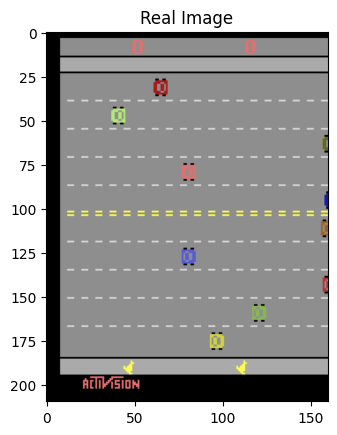

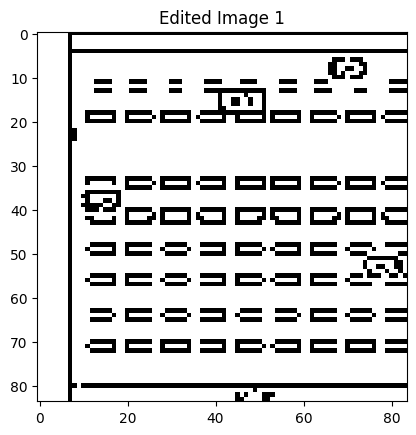

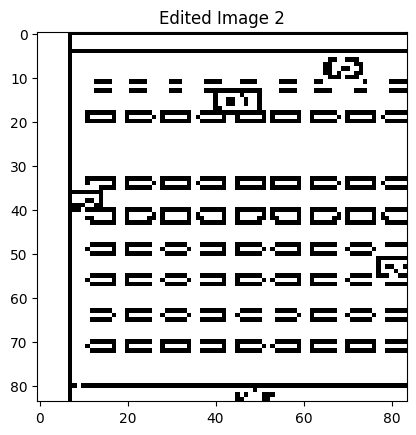

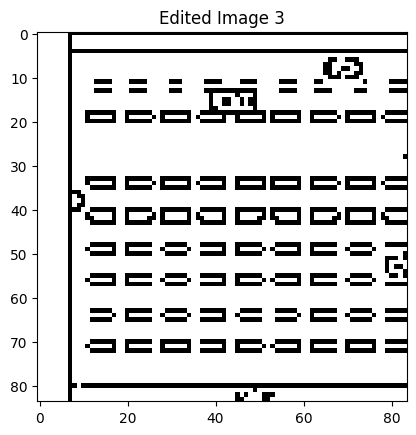

In [14]:
agent.show_screen()

In [15]:
agent.train()

Episode:      5 | MA50:  +18.0 | Episode Reward:   18.0 | Steps:  2048 | Actions: [ 305. 1631.  112.]
Episode:     10 | MA50:  +18.5 | Episode Reward:   19.0 | Steps:  2048 | Actions: [ 165. 1821.   62.]
Saving model to Freeway/, best episode score: 19.0
Episode:     15 | MA50:  +20.0 | Episode Reward:   23.0 | Steps:  2048 | Actions: [  55. 1942.   51.]
Saving model to Freeway/, best episode score: 23.0
Episode:     20 | MA50:  +21.0 | Episode Reward:   24.0 | Steps:  2048 | Actions: [  39. 2002.    7.]
Saving model to Freeway/, best episode score: 24.0
Episode:     25 | MA50:  +21.2 | Episode Reward:   22.0 | Steps:  2048 | Actions: [  67. 1952.   29.]
Episode:     30 | MA50:  +21.3 | Episode Reward:   22.0 | Steps:  2048 | Actions: [  40. 1993.   15.]
Episode:     35 | MA50:  +21.4 | Episode Reward:   22.0 | Steps:  2048 | Actions: [  32. 2000.   16.]
Episode:     40 | MA50:  +21.4 | Episode Reward:   21.0 | Steps:  2048 | Actions: [2.000e+00 2.043e+03 3.000e+00]
Episode:     45 | M

Episode:    355 | MA50:  +24.0 | Episode Reward:   27.0 | Steps:  2048 | Actions: [   5. 2020.   23.]
Episode:    360 | MA50:  +24.1 | Episode Reward:   25.0 | Steps:  2048 | Actions: [  39. 1943.   66.]
Episode:    365 | MA50:  +24.0 | Episode Reward:   22.0 | Steps:  2048 | Actions: [  14. 2020.   14.]
Episode:    370 | MA50:  +24.1 | Episode Reward:   25.0 | Steps:  2048 | Actions: [  31. 1964.   53.]
Episode:    375 | MA50:  +24.2 | Episode Reward:   23.0 | Steps:  2048 | Actions: [  56. 1907.   85.]
Episode:    380 | MA50:  +24.3 | Episode Reward:   28.0 | Steps:  2048 | Actions: [  33. 1961.   54.]
Saving model to Freeway/, best episode score: 28.0
Episode:    385 | MA50:  +24.3 | Episode Reward:   23.0 | Steps:  2048 | Actions: [  20. 1937.   91.]
Episode:    390 | MA50:  +24.3 | Episode Reward:   25.0 | Steps:  2048 | Actions: [   4. 2032.   12.]
Episode:    395 | MA50:  +24.4 | Episode Reward:   25.0 | Steps:  2048 | Actions: [  16. 1992.   40.]
Episode:    400 | MA50:  +24.4 

Episode:    725 | MA50:  +29.5 | Episode Reward:   29.0 | Steps:  2048 | Actions: [  69. 1858.  121.]
Episode:    730 | MA50:  +29.5 | Episode Reward:   32.0 | Steps:  2048 | Actions: [  27. 1908.  113.]
Episode:    735 | MA50:  +29.6 | Episode Reward:   32.0 | Steps:  2048 | Actions: [  30. 1912.  106.]
Episode:    740 | MA50:  +29.6 | Episode Reward:   29.0 | Steps:  2048 | Actions: [  42. 1919.   87.]
Episode:    745 | MA50:  +29.6 | Episode Reward:   27.0 | Steps:  2048 | Actions: [  38. 1924.   86.]
Episode:    750 | MA50:  +29.7 | Episode Reward:   32.0 | Steps:  2048 | Actions: [  57. 1856.  135.]
Episode:    755 | MA50:  +29.7 | Episode Reward:   31.0 | Steps:  2048 | Actions: [  39. 1938.   71.]
Episode:    760 | MA50:  +29.8 | Episode Reward:   32.0 | Steps:  2048 | Actions: [  52. 1857.  139.]
Episode:    765 | MA50:  +29.9 | Episode Reward:   31.0 | Steps:  2048 | Actions: [  29. 1948.   71.]
Episode:    770 | MA50:  +29.9 | Episode Reward:   32.0 | Steps:  2048 | Actions: 

Episode:   1090 | MA50:  +31.5 | Episode Reward:   29.0 | Steps:  2048 | Actions: [  72. 1868.  108.]
Episode:   1095 | MA50:  +31.5 | Episode Reward:   33.0 | Steps:  2048 | Actions: [  79. 1840.  129.]
Saving model to Freeway/, best episode score: 33.0
Episode:   1100 | MA50:  +31.5 | Episode Reward:   29.0 | Steps:  2048 | Actions: [  31. 1938.   79.]
Episode:   1105 | MA50:  +31.4 | Episode Reward:   31.0 | Steps:  2048 | Actions: [  58. 1827.  163.]
Episode:   1110 | MA50:  +31.4 | Episode Reward:   31.0 | Steps:  2048 | Actions: [  32. 1870.  146.]
Episode:   1115 | MA50:  +31.4 | Episode Reward:   32.0 | Steps:  2048 | Actions: [  28. 1836.  184.]
Episode:   1120 | MA50:  +31.5 | Episode Reward:   32.0 | Steps:  2048 | Actions: [  38. 1882.  128.]
Episode:   1125 | MA50:  +31.5 | Episode Reward:   32.0 | Steps:  2048 | Actions: [  19. 1829.  200.]
Episode:   1130 | MA50:  +31.5 | Episode Reward:   33.0 | Steps:  2048 | Actions: [  22. 1855.  171.]
Saving model to Freeway/, best 

Episode:   1435 | MA50:  +32.9 | Episode Reward:   33.0 | Steps:  2048 | Actions: [  20. 1855.  173.]
Episode:   1440 | MA50:  +32.9 | Episode Reward:   32.0 | Steps:  2048 | Actions: [  23. 1873.  152.]
Episode:   1445 | MA50:  +32.9 | Episode Reward:   34.0 | Steps:  2048 | Actions: [  44. 1835.  169.]
Saving model to Freeway/, best episode score: 34.0
Episode:   1450 | MA50:  +33.0 | Episode Reward:   34.0 | Steps:  2048 | Actions: [  24. 1861.  163.]
Saving model to Freeway/, best episode score: 34.0
Episode:   1455 | MA50:  +33.0 | Episode Reward:   34.0 | Steps:  2048 | Actions: [  30. 1858.  160.]
Saving model to Freeway/, best episode score: 34.0
Episode:   1460 | MA50:  +33.0 | Episode Reward:   34.0 | Steps:  2048 | Actions: [  50. 1822.  176.]
Saving model to Freeway/, best episode score: 34.0
Episode:   1465 | MA50:  +33.0 | Episode Reward:   34.0 | Steps:  2048 | Actions: [  36. 1874.  138.]
Saving model to Freeway/, best episode score: 34.0
Episode:   1470 | MA50:  +33.0 

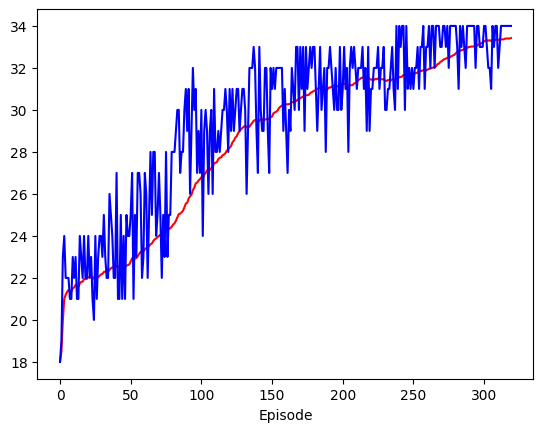

In [16]:
agent.plot()

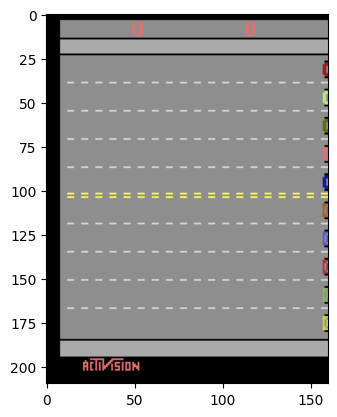

In [17]:
agent.play()